In [38]:
import numpy as np
import scipy.optimize as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import time

## Problem 1 (b, c, d, e, f) Newton's Algorithm - Shriram R

In [30]:
def rosen(x, a=1, b=100):
    """
    Rosenbrock function definition
    """
    return (a-x[0])**2 + b*((x[1]-x[0]**2)**2)

In [31]:
def rosen_grad(x, a=1, b=100):
    """
    Gradient for Rosenbrock function
    """
    return np.array([2*(x[0]-a)-4*b*x[0]*(x[1]-x[0]**2),
                    2*b*(x[1]-x[0]**2)]).transpose().reshape(-1, 1)

In [32]:
def rosen_hess(x, a=1, b=100):
    """
    Hessian for Rosenbrock function
    """
    return np.array([[12*b*x[0]**2 - 4*b*x[1] + 2, -4*b*x[0]],
                     [-4*b*x[0], 2*b]])

In [33]:
def newton(initial_guess, conc_ratio=0.5, c=10e-4, init_alpha=1.0, stop=1.0e-8, max_iterations=1000):
    """
    Newton's Algorithm
    """
    x = initial_guess
    grad = rosen_grad(x)
    grad_norm = np.linalg.norm(grad)
    i = 0
    true_x = np.array([1.0, 1.0])
    iterates = []
    alphas = []
    rosens = []
    rel_error = []
    conv_rate = []
    while i < max_iterations and grad_norm > stop:
        alpha = init_alpha # Initialize Alpha
        p = -1 * np.matmul(np.linalg.inv(rosen_hess(x)), grad).reshape(2) # Update P
        f = rosen(x)
        rhs = f + c*alpha*np.matmul(grad.transpose(),p) # RHS for armijo condition
        while rosen(x+alpha*p) > rhs:
            alpha = alpha * conc_ratio # Reduce alpha
        iterates.append(x)
        alphas.append(alpha)
        rosens.append(f)
        rel_error.append(np.linalg.norm(true_x - x) / np.linalg.norm(true_x))
        x = x + alpha*p # Update iterate
        grad = rosen_grad(x)
        grad_norm = np.linalg.norm(grad)
        i += 1
    
    for i in range(len(iterates)-1):
        conv_rate.append(np.linalg.norm(iterates[i+1]-true_x)/(np.linalg.norm(iterates[i]-true_x))**2)
    
    return iterates, alphas, rosens, rel_error, conv_rate              
        
    

In [34]:
def plot_newton_output(iterates, alphas, rel_error, rosens, conv_rate):
    """
    Plot required values
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 4))
    
    # Alpha
    x_axis = [str(i) for i in range(len(iterates))]
    axes[0].plot(x_axis, alphas)
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Alpha (log scale)")
    axes[0].set_ylim(ymin=10e-2)
    axes[0].set_ylim(ymax=5)
    axes[0].minorticks_on()
    axes[0].grid(b=True, which='both', linestyle='-')

    # Iterates
    axes[1].plot(x_axis, rel_error)
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Iterate Relative Error (log scale)")
    axes[1].set_ylim(ymin=10e-17)
    axes[1].set_ylim(ymax=10e2)
    axes[1].minorticks_on()
    axes[1].grid(b=True, which='both', linestyle='-')

    # Objective Function
    axes[2].plot(x_axis, rosens)
    axes[2].set_yscale("log")
    axes[2].set_xlabel("Iteration")
    axes[2].set_ylabel("Objective Function (log scale)") 
    axes[2].set_ylim(ymin=10e-10)
    axes[2].set_ylim(ymax=100)
    axes[2].minorticks_on()
    axes[2].grid(b=True, which='both', linestyle='-')
    
    # Convergence Rate
    axes[3].plot(x_axis[1:], conv_rate)
    axes[3].set_xlabel("Iteration")
    axes[3].set_ylabel("Q-Convergence")
    axes[3].minorticks_on()
    axes[3].grid(b=True, which='both', linestyle='-')
    

[-1]


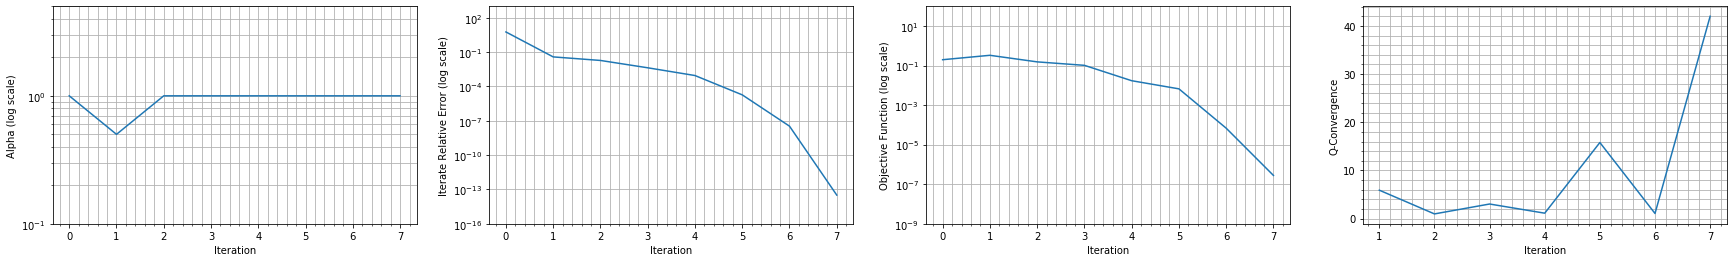

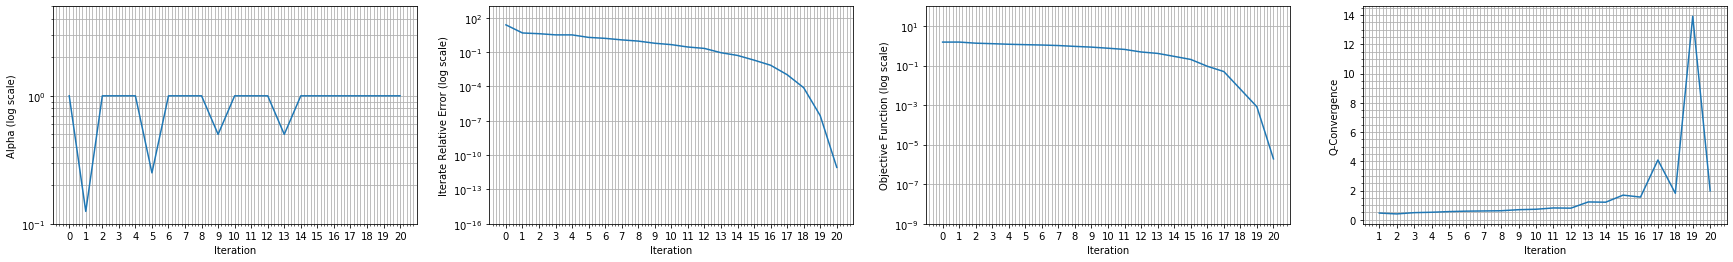

In [39]:
# Run Newton's Method
initial_guess_1 = np.array([1.2, 1.2]).transpose()
initial_guess_2 = np.array([-1.2, 1.0]).transpose()

iterates, alphas, rosens, rel_error, conv_rate = newton(initial_guess_1)
plot_newton_output(iterates, alphas, rosens, rel_error, conv_rate)

iterates, alphas, rosens, rel_error, conv_rate = newton(initial_guess_2)
plot_newton_output(iterates, alphas, rosens, rel_error, conv_rate)


We observe quadratic rate of convergence as indicated in the Q-convergence plot where the ratio remains fairly constant and bounded. The ratio shoots up during later iterations due to numerical instability caused by dividing a very small value by another very small value. 

In [36]:
# Run built-in newton optimizer
res = sc.minimize(rosen, initial_guess_1, method='TNC', tol=1.0e-8)
print(res)
res = sc.minimize(rosen, initial_guess_2, method='TNC', tol=1.0e-8)
print(res)

     fun: 9.677100838034292e-12
     jac: array([1.75157768e-06, 5.23280656e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 35
     nit: 10
  status: 1
 success: True
       x: array([1.0000031 , 1.00000623])
     fun: 7.14876289130245e-12
     jac: array([1.86593035e-06, 4.73920789e-06])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 81
     nit: 23
  status: 1
 success: True
       x: array([1.00000267, 1.00000535])


In [13]:
# Time measurement

# Backtracking
start=time.process_time()
for i in range(1000):
    newton(initial_guess_2)
end=time.process_time()
print("Backtracking (ms) "), print((end-start));

# Built-in
start=time.process_time()
for i in range(1000):
    sc.minimize(rosen, initial_guess_2, method='TNC', tol=1.0e-8)
end=time.process_time()
print("Built-in (ms)"), print((end-start));

Backtracking (ms) 
1.28125
Built-in (ms)
1.15625


The built-in function takes comparatively lesser time than our implementation and almost same no. of iterations which indicates the optimization of built-in program to efficiently perform matrix computations. However, we need to evaluate on a larger problem to conclusively determine the scalability and performance of the implementation.

# 4 (a) BFGS Method

In [20]:
def bfgs_hessian_update(hess_inv, s, y):
    """
    BFGS update using Sherman-Morrison Formula
    """
    sy = np.matmul(s.transpose(), y)
    yby = np.matmul(y.transpose(), np.matmul(hess_inv, y))
    ss = np.matmul(s, s.transpose())
    bys = np.matmul(hess_inv, np.matmul(y, s.transpose()))
    syb = np.matmul(s, np.matmul(y.transpose(), hess_inv))
    first = (sy + yby) * ss / (sy**2)
    second = (bys + syb) / sy
    return hess_inv + first - second

In [23]:
def bfgs(initial_guess, conc_ratio=0.5, c=10e-4, init_alpha=1.0, stop=1.0e-8, max_iterations=100):
    """
    BFGS Quasi-Newton Algorithm
    """
    i = 0
    x = initial_guess
    grad = rosen_grad(x)
    grad_norm = np.linalg.norm(grad)
    hess_inv = np.linalg.inv(rosen_hess(x))
    true_x = np.array([1.0, 1.0])
    iterates = []
    alphas = []
    rosens = []
    rel_error = []
    conv_rate = []
    
    while i < max_iterations and grad_norm > stop:
        p = -1 * np.matmul(hess_inv, grad).reshape(2) # Update P
        alpha = init_alpha
        f = rosen(x)
        rhs = f + c*alpha*np.matmul(grad.transpose(),p) # RHS for armijo condition
        while rosen(x+alpha*p) > rhs:
            alpha = alpha * conc_ratio
        iterates.append(x)
        alphas.append(alpha)
        rosens.append(f)
        rel_error.append(np.linalg.norm(true_x - x) / np.linalg.norm(true_x))
        s = alpha*p.reshape(-1, 1)
        x = x + alpha*p 
        new_grad = rosen_grad(x)
        y = new_grad - grad
        hess_inv = bfgs_hessian_update(hess_inv, s, y) # Get Hessian inverse from BFGS
        grad = new_grad
        grad_norm = np.linalg.norm(grad)
        i += 1
    
    for i in range(len(iterates)-1):
        conv_rate.append(np.linalg.norm(iterates[i+1]-true_x)/(np.linalg.norm(iterates[i]-true_x)))
    
    return iterates, alphas, rosens, rel_error, conv_rate

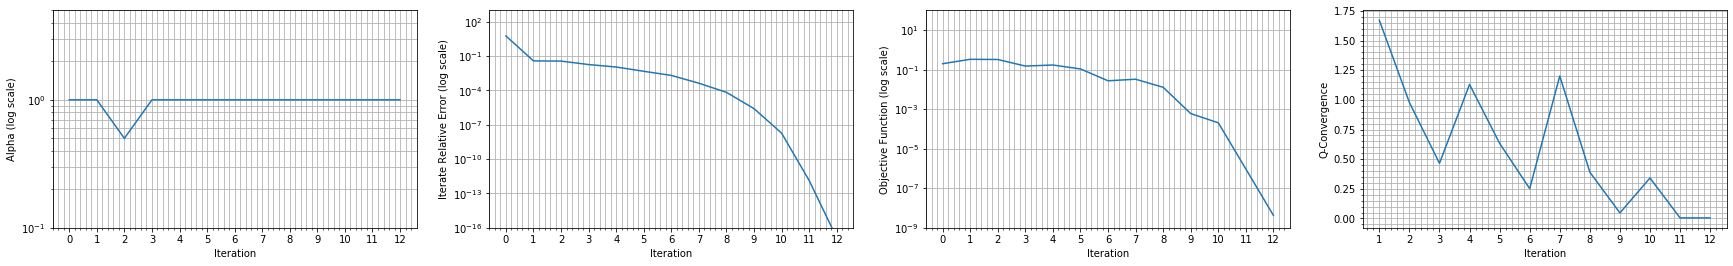

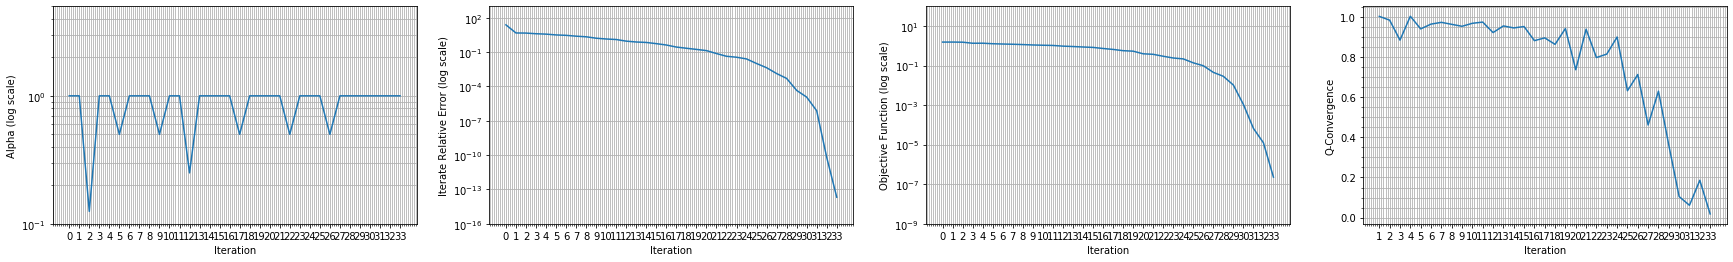

In [24]:
# Run BFGS Method
initial_guess_1 = np.array([1.2, 1.2]).transpose()
initial_guess_2 = np.array([-1.2, 1.0]).transpose()

iterates, alphas, rosens, rel_error, conv_rate = bfgs(initial_guess_1)
plot_newton_output(iterates, alphas, rosens, rel_error, conv_rate)

iterates, alphas, rosens, rel_error, conv_rate = bfgs(initial_guess_2)
plot_newton_output(iterates, alphas, rosens, rel_error, conv_rate)

BFGS takes slighlty more no. of iterations to converge compared to newton's method. The order of convergence is found to be superlinear as the Q-convergence ratio goes to zero.